# **Part I: Text Classification** #

# Step 1: Loading 20 Newsgroups Dataset

In [5]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

print("\nSample post:\n", newsgroups_train['data'][1000])
print("\nSample target:", newsgroups_train['target'][1000])

print("\nTraining samples:", len(newsgroups_train['data']))
print("\nTest samples:", len(newsgroups_test['data']))


Sample post:
 From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)
Subject: Diamond SS24X, Win 3.1, Mouse cursor
Organization: National Library of Medicine
Lines: 10


Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email

--Don Lindbergh
dabl2@lhc.nlm.nih.gov


Sample target: 2

Training samples: 11314

Test samples: 7532


## Step 1.1: Preprocessing

In [8]:
# Target names
target_names = newsgroups_train["target_names"]
print("\nClasses:\n", target_names)

target_id = newsgroups_train["target"][1000]
print("\nClass of previous message:", target_names[target_id])


Classes:
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Class of previous message: comp.os.ms-windows.misc


## Step 1.2: Sequences

In [16]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = newsgroups_train["data"]
texts_test = newsgroups_test["data"]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

print("\nSequence[0]:\n", sequences[0])
print("\nSequence length: ", len(sequences))


Sequence[0]:
 [14, 4308, 1350, 15, 11126, 38, 250, 29, 42, 298, 9, 17, 95, 78, 91, 4308, 1350, 15, 34, 77, 3, 2952, 610, 1767, 32, 211, 8, 26, 1308, 27, 171, 66, 47, 123, 9879, 63, 16, 17, 298, 8, 708, 1, 86, 263, 11, 26, 4, 36, 1497, 2266, 298, 1162, 2, 18, 14, 1, 1347, 13637, 843, 15448, 11, 26, 337, 4, 1, 4017, 80, 182, 484, 7, 1376, 1, 844, 8164, 26, 1835, 14, 1, 816, 3, 1, 726, 17, 9, 44, 8, 88, 27, 171, 39, 4, 828, 273, 1078, 2908, 198, 3, 2804, 153, 17, 298, 9, 239, 628, 25, 808, 357, 13, 21, 16, 17, 384, 298, 181, 112, 188, 206, 1498, 1341, 2, 13, 35, 58, 7860]

Sequence length:  11314


## Step 1.3: Tokenize the text

In [20]:
word_index = tokenizer.word_index
index_word = tokenizer.index_word
print('\nFound unique tokens:  %s' % len(word_index))
print("\nJoined Text:\n", " ".join([index_word[i] for i in sequences[0]]))

# Analyze sequence lengths
seq_lens = [len(s) for s in sequences]
print("\nAverage length: %0.1f" % np.mean(seq_lens))
print("\nMax length: %d" % max(seq_lens))


Found unique tokens:  134142

Joined Text:
 from wam umd edu where's my thing subject what car is this nntp posting host wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can a model name engine specs years of production where this car is made history or whatever info you have on this looking car please e mail thanks il brought to you by your neighborhood

Average length: 302.5

Max length: 15365


## Step 1.4: Plotting

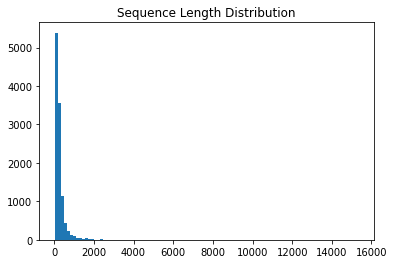

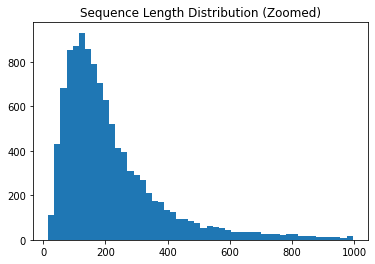

np.sum:  361


In [22]:
plt.hist(seq_lens, bins=100)
plt.title("Sequence Length Distribution")
plt.show()

plt.hist([l for l in seq_lens if l < 1000], bins=50)
plt.title("Sequence Length Distribution (Zoomed)")
plt.show()

print("np.sum: ", np.sum(np.array(seq_lens)>1000))

## Step 1.5: Tensor

In [25]:
MAX_SEQUENCE_LENGTH = 1000

# Pad sequences
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

# Convert labels to one-hot encoding
y_train = newsgroups_train["target"]
y_test = newsgroups_test["target"]
print('\nlabel tensor:', y_train[100])

y_train = to_categorical(np.asarray(y_train))
print('\nCategorical label tensor:\n', y_train[100])
print('\nShape of label tensor:', y_train.shape)

Shape of data tensor: (11314, 1000)
Shape of data test tensor: (7532, 1000)

label tensor: 6

Categorical label tensor:
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Shape of label tensor: (11314, 20)


# Step 2: Building a Simple CBOW Model

In [27]:
from keras.layers import Dense, Input, GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# Build the model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print("\nSummary:", model.summary())

# Train the model
history = model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

# Evaluate on test set
test_pred = model.predict(x_test)
test_classes = np.argmax(test_pred, axis=-1)
test_acc = np.mean(test_classes == y_test)
print("\nTest accuracy:", test_acc)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
Total params: 1,001,020
Trainable params: 1,001,020
Non-trainable params: 0
_________________________________________________________________

Summary:
 None
Train on 10182 samples, validate on 1132 samples
Epoch 1/10
10182/10182 [==============================] - 3s 284us/step - loss: 2.9866 - acc: 0.0731 - val_loss: 2.9787 - val_acc: 0.0866
Epoch 2/10
10182/10182 [====================

# Step 3: Building a More Complex Model with Conv1D


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0  

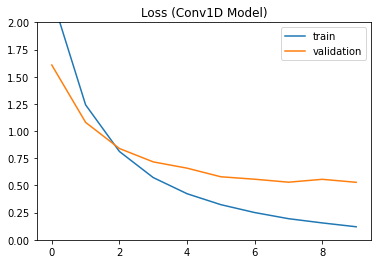

In [28]:
from keras.layers import Conv1D, MaxPooling1D

# Build the Conv1D model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = GlobalAveragePooling1D()(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model_conv = Model(sequence_input, predictions)
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print("\nSummary:", model_conv.summary())

# Train the model
history_conv = model_conv.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

# Evaluate on test set
test_pred_conv = model_conv.predict(x_test)
test_classes_conv = np.argmax(test_pred_conv, axis=-1)
print("\nTest accuracy (Conv1D):", np.mean(test_classes_conv == y_test))

# Plot loss
plt.plot(history_conv.history['loss'], label='train')
plt.plot(history_conv.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss (Conv1D Model)')
plt.show()

# Step 4: Building a Model with LSTM

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 996, 64)           16064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 195, 64)           20544     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                3302

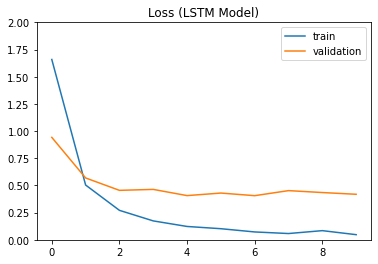

In [30]:
from keras.layers import LSTM

# Build the LSTM model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x) # MaxPool divides the length of the sequence by 5
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = LSTM(64)(x) # LSTM layer with a hidden size of 64
predictions = Dense(20, activation='softmax')(x)

model_lstm = Model(sequence_input, predictions)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print("\nSummary:", model_lstm.summary())

# Train the model
history_lstm = model_lstm.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

# Evaluate on test set
test_pred_lstm = model_lstm.predict(x_test)
test_classes_lstm = np.argmax(test_pred_lstm, axis=-1)
print("\nTest accuracy (LSTM):", np.mean(test_classes_lstm == y_test))

# Plot loss
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss (LSTM Model)')
plt.show()

# Step 5: Visualizing Word Embeddings with t-SNE

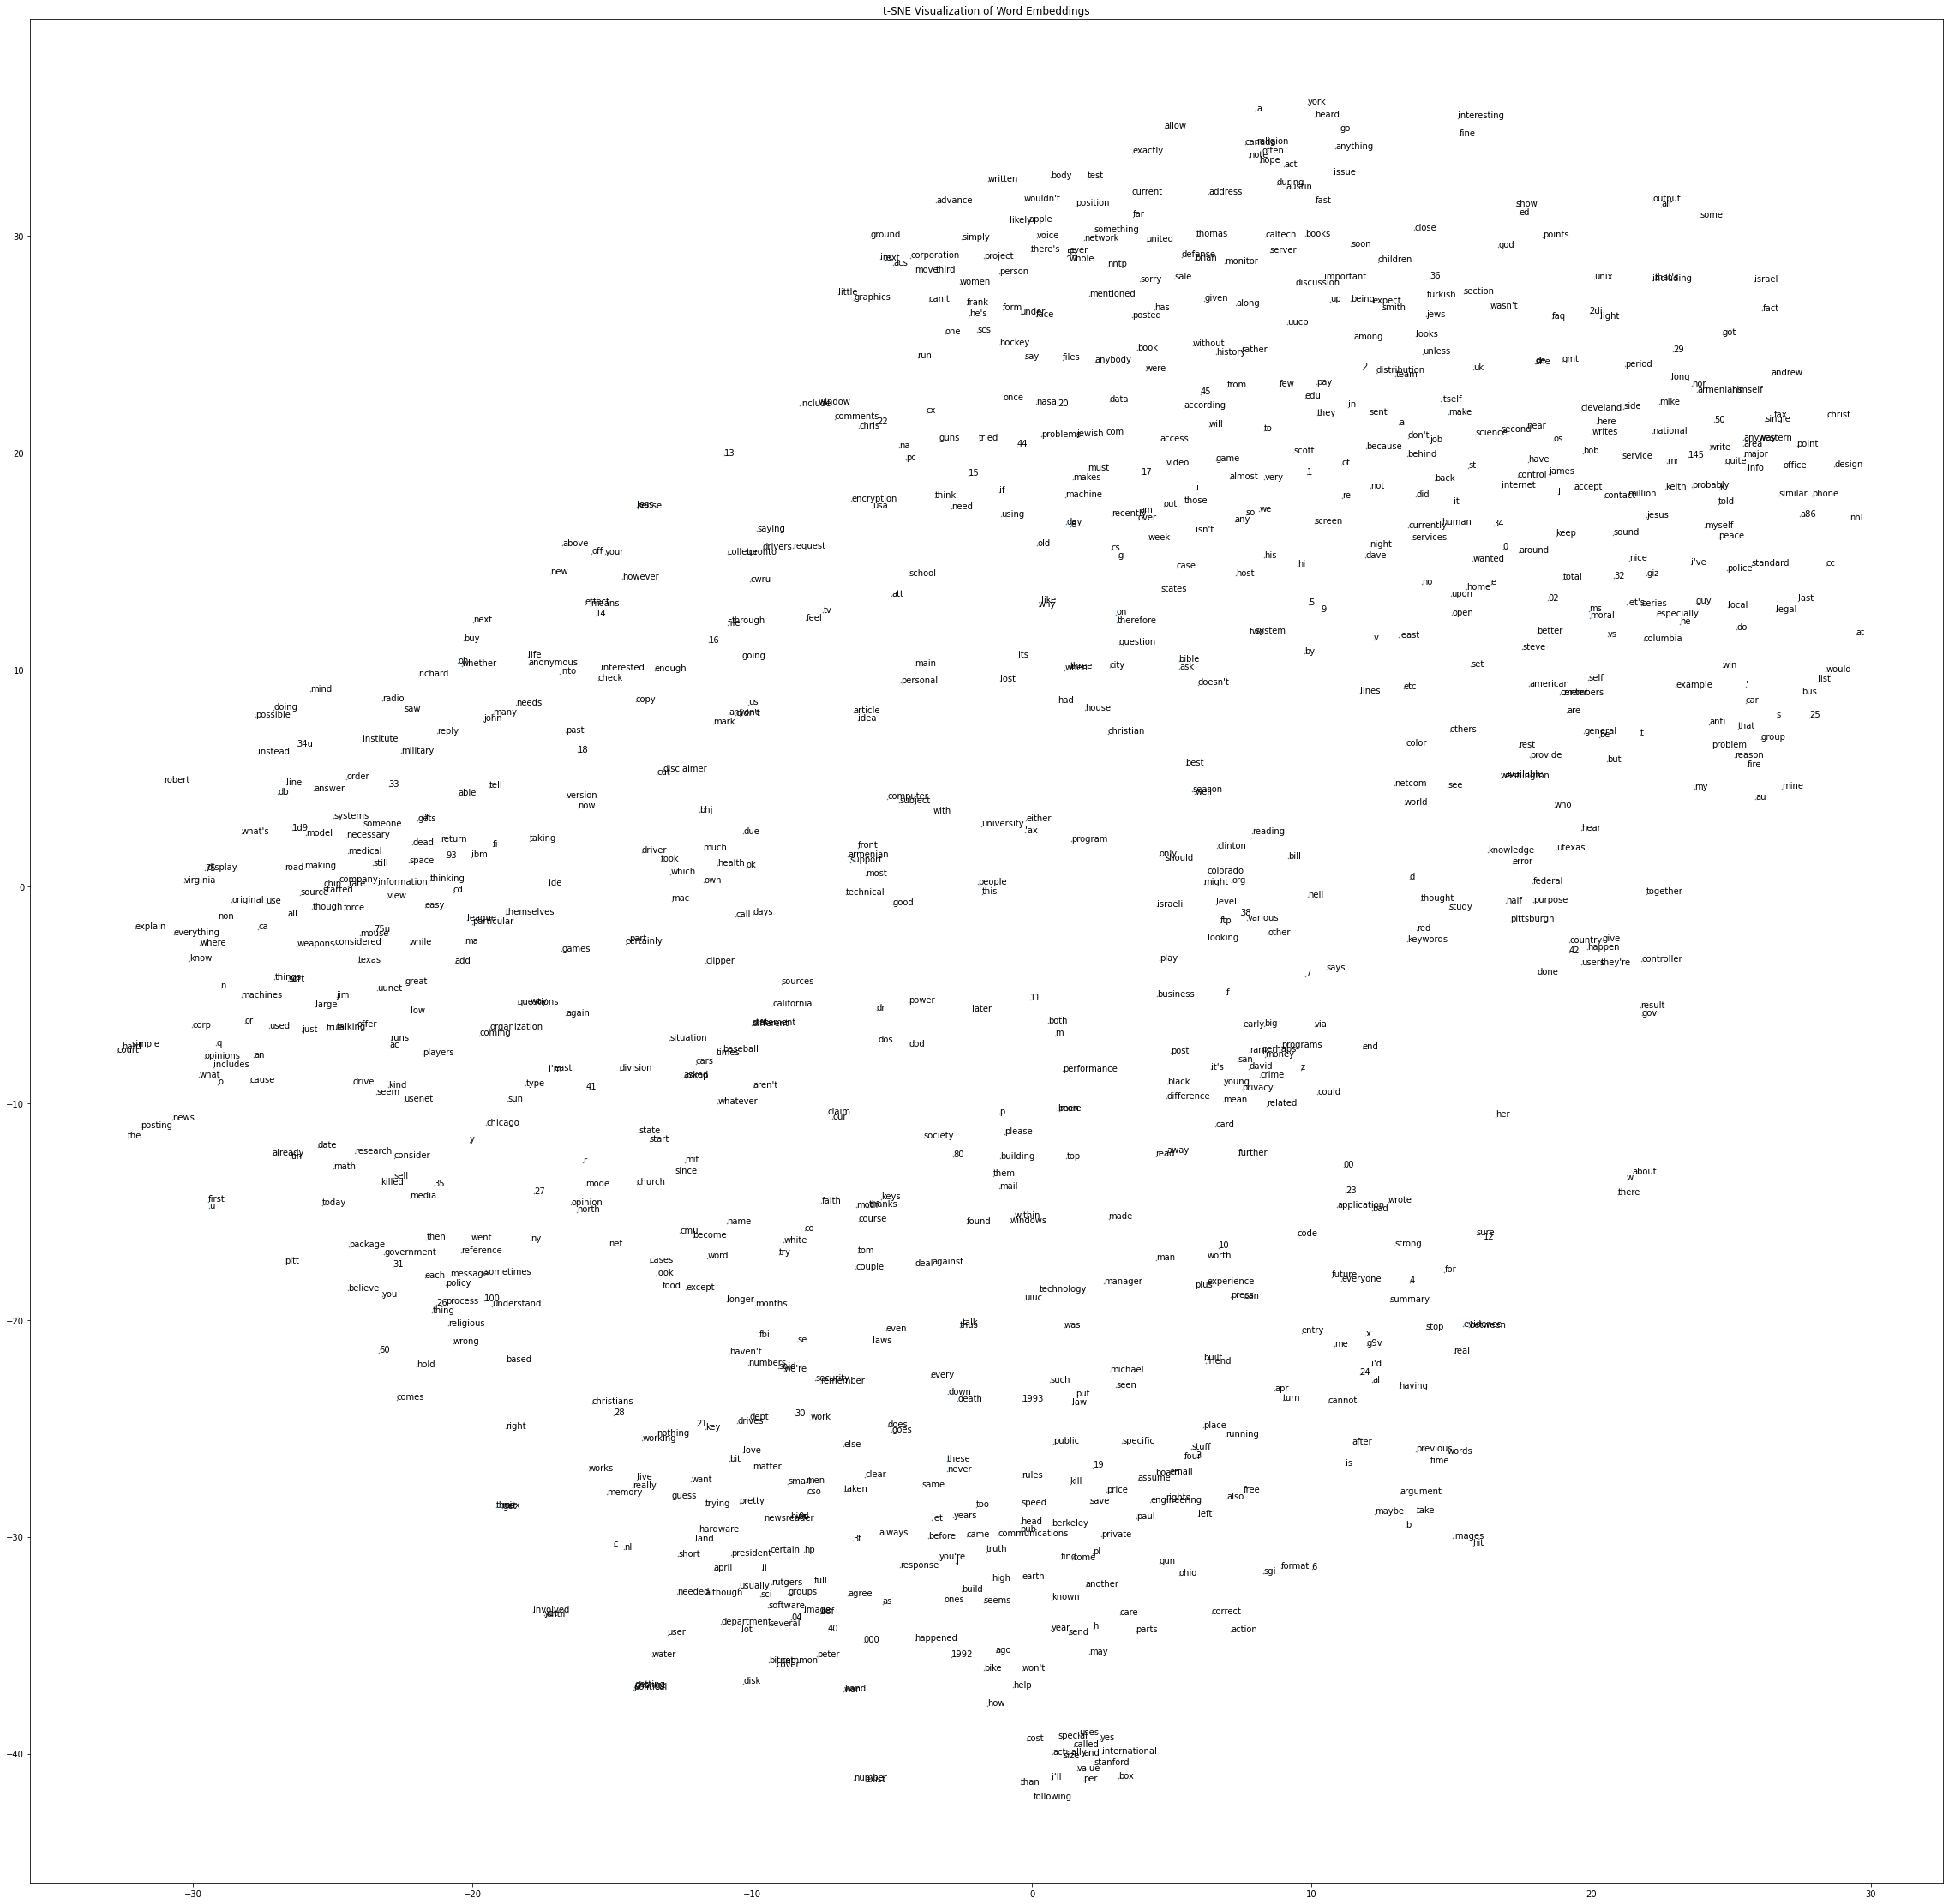

In [31]:
from sklearn.manifold import TSNE

# Extract embeddings
embeddings = model_lstm.layers[1].get_weights()[0]
embeddings = np.vstack(embeddings)
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
embeddings_normed = embeddings / norms

# Apply t-SNE
word_emb_tsne = TSNE(perplexity=30).fit_transform(embeddings_normed[:1000])

# Plot
plt.figure(figsize=(40, 40))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)

for idx in range(1000):
    plt.annotate(index_word[idx+1], xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]), xytext=(0, 0), textcoords='offset points')
plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

# **Part II: Seq2Seq Translation** #

# Step 1: Generating the Dataset #

In [76]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import Random
from math import log10

from Files.french_numbers import *

print("\nSome Values in Dataset:")
for x in [21, 80, 81, 300, 213, 1100, 1201, 301000, 80080]:
    print(str(x).rjust(6), to_french_phrase(x))

# Generate and split the dataset
numbers, french_numbers = generate_translations(low=1, high=int(1e6) - 1, exhaustive=5000, random_seed=0)
num_train, num_dev, fr_train, fr_dev = train_test_split(numbers, french_numbers, test_size=0.5, random_state=0)
num_val, num_test, fr_val, fr_test = train_test_split(num_dev, fr_dev, test_size=0.5, random_state=0)

print("\nTraining samples:", len(fr_train))
print("\nValidation samples:", len(fr_val))
print("\nTest samples:", len(fr_test))

print("\nfr_train:")
for i, (fr_phrase, num_phrase) in enumerate(zip(fr_train[:5], num_train[:5])):
    print(f"{num_phrase.rjust(6)} {fr_phrase}")

print("\nfr_val:")
for i, fr_phrase, num_phrase in zip(range(5), fr_val[:5], num_val[:5]):
    print(f"{num_phrase.rjust(6)} {fr_phrase}")


Some Values in Dataset:
    21 vingt et un
    80 quatre vingts
    81 quatre vingt un
   300 trois cents
   213 deux cent treize
  1100 mille cent
  1201 mille deux cent un
301000 trois cent un mille
 80080 quatre vingt mille quatre vingts

Training samples: 10000

Validation samples: 5000

Test samples: 5000

fr_train:
  2882 deux mille huit cent quatre vingt deux
372200 trois cent soixante douze mille deux cents
  2193 deux mille cent quatre vingt treize
996418 neuf cent quatre vingt seize mille quatre cent dix huit
  9172 neuf mille cent soixante douze

fr_val:
  2804 deux mille huit cent quatre
  3898 trois mille huit cent quatre vingt dix huit
 82996 quatre vingt deux mille neuf cent quatre vingt seize
366346 trois cent soixante six mille trois cent quarante six
 56006 cinquante six mille six


# Step 2: Tokenize

In [77]:
PAD, GO, EOS, UNK = START_VOCAB = ['_PAD', '_GO', '_EOS', '_UNK']

def tokenize(sentence, word_level=True):
    if word_level:
        return sentence.split()
    else:
        return [sentence[i:i + 1] for i in range(len(sentence))]

print(tokenize('1234', word_level=False))
print(tokenize('mille deux cent trente quatre', word_level=True))

['1', '2', '3', '4']
['mille', 'deux', 'cent', 'trente', 'quatre']


# Step 3: Build Vocabulary

In [78]:
def build_vocabulary(tokenized_sequences):
    rev_vocabulary = START_VOCAB[:]
    unique_tokens = set()
    for tokens in tokenized_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary


tokenized_fr_train = [tokenize(s, word_level=True) for s in fr_train]
tokenized_num_train = [tokenize(s, word_level=False) for s in num_train]

fr_vocab, rev_fr_vocab = build_vocabulary(tokenized_fr_train)
num_vocab, rev_num_vocab = build_vocabulary(tokenized_num_train)

print("\nfr_vocab length:", len(fr_vocab))
print("\nnum_vocab length:", len(num_vocab))

print("\nFrench Vocabulary:")
for k, v in sorted(fr_vocab.items()):
    print(k.rjust(10), v)

print("\nNumeric Vocabulary:")
for k, v in sorted(num_vocab.items()):
    print(k.rjust(10), v)

print("\nrev_fr_vocab:\n", rev_fr_vocab)
print("\nrev_num_vocab:\n", rev_num_vocab)


fr_vocab length: 30

num_vocab length: 14

French Vocabulary:
      _EOS 2
       _GO 1
      _PAD 0
      _UNK 3
      cent 4
     cents 5
      cinq 6
 cinquante 7
      deux 8
       dix 9
     douze 10
        et 11
      huit 12
     mille 13
      neuf 14
      onze 15
  quarante 16
  quatorze 17
    quatre 18
    quinze 19
     seize 20
      sept 21
       six 22
  soixante 23
    treize 24
    trente 25
     trois 26
        un 27
     vingt 28
    vingts 29

Numeric Vocabulary:
         0 4
         1 5
         2 6
         3 7
         4 8
         5 9
         6 10
         7 11
         8 12
         9 13
      _EOS 2
       _GO 1
      _PAD 0
      _UNK 3

rev_fr_vocab:
 ['_PAD', '_GO', '_EOS', '_UNK', 'cent', 'cents', 'cinq', 'cinquante', 'deux', 'dix', 'douze', 'et', 'huit', 'mille', 'neuf', 'onze', 'quarante', 'quatorze', 'quatre', 'quinze', 'seize', 'sept', 'six', 'soixante', 'treize', 'trente', 'trois', 'un', 'vingt', 'vingts']

rev_num_vocab:
 ['_PAD', '_GO', '_EO

## Step 3.1: Build Vocabulary (Exercise)

In [79]:
# Build a shared vocabulary with explicit deduplication
shared_tokens = set(START_VOCAB)  # Start with special tokens

# Add French tokens
fr_tokens = [token for token in rev_fr_vocab if token not in START_VOCAB]
shared_tokens.update(fr_tokens)

# Add numeric tokens
num_tokens = [token for token in rev_num_vocab if token not in START_VOCAB]
shared_tokens.update(num_tokens)

# Convert to a sorted list for shared_rev_vocab
shared_rev_vocab = START_VOCAB + sorted(shared_tokens - set(START_VOCAB))
shared_vocab = {token: i for i, token in enumerate(shared_rev_vocab)}

# Print vocabulary information
print("\nShared vocabulary size:", len(shared_vocab))
print("\nSample shared vocab (first 10):\n", shared_rev_vocab[:10])
print("\nSample shared vocab (last 10):\n", shared_rev_vocab[-10:])


Shared vocabulary size: 40

Sample shared vocab (first 10):
 ['_PAD', '_GO', '_EOS', '_UNK', '0', '1', '2', '3', '4', '5']

Sample shared vocab (last 10):
 ['seize', 'sept', 'six', 'soixante', 'treize', 'trente', 'trois', 'un', 'vingt', 'vingts']


# Step 4: Input & Output

In [80]:
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    input_tokens = source_tokens[::-1] if reverse_source else source_tokens
    input_tokens += [GO]
    input_tokens += target_tokens
    output_tokens = target_tokens + [EOS]
    return input_tokens, output_tokens

input_tokens, output_tokens = make_input_output(['quatre','cent', 'soixante', 'seize'], ['4', '7', '6'])

print("\nInput Tokens:\n", input_tokens)
print("\nOutput Tokens:\n", output_tokens)


Input Tokens:
 ['seize', 'soixante', 'cent', 'quatre', '_GO', '4', '7', '6']

Output Tokens:
 ['4', '7', '6', '_EOS']


## Step 4.1: Input & Output (Seq2Seq)

In [81]:
all_tokenized_sequences = tokenized_fr_train + tokenized_num_train
shared_vocab, rev_shared_vocab = build_vocabulary(all_tokenized_sequences)

max_length = 20  # found by introspection of our training set

def vectorize_corpus(source_sequences, target_sequences, shared_vocab, word_level_source=True, word_level_target=True, max_length=max_length):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    source_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    source_ids.fill(shared_vocab[PAD])
    target_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    target_ids.fill(shared_vocab[PAD])
    numbered_pairs = zip(range(n_sequences), source_sequences, target_sequences)
    for i, source_seq, target_seq in numbered_pairs:
        source_tokens = tokenize(source_seq, word_level=word_level_source)
        target_tokens = tokenize(target_seq, word_level=word_level_target)
        
        in_tokens, out_tokens = make_input_output(source_tokens, target_tokens)
        
        in_token_ids = [shared_vocab.get(t, UNK) for t in in_tokens]
        source_ids[i, -len(in_token_ids):] = in_token_ids
    
        out_token_ids = [shared_vocab.get(t, UNK) for t in out_tokens]
        target_ids[i, -len(out_token_ids):] = out_token_ids

    return source_ids, target_ids

X_train, Y_train = vectorize_corpus(fr_train, num_train, shared_vocab, word_level_target=False)
X_val, Y_val = vectorize_corpus(fr_val, num_val, shared_vocab, word_level_target=False)
X_test, Y_test = vectorize_corpus(fr_test, num_test, shared_vocab, word_level_target=False)

print("\nX_train shape:", X_train.shape)
print("\nY_train shape:", Y_train.shape)
print("\nCorresponding French phrase:", fr_train[5])
print("\nCorresponding number:", num_train[5])
print("\nSample input sequence:", X_train[5])
print("\nSample output sequence:", Y_train[5])


X_train shape: (10000, 20)

Y_train shape: (10000, 20)

Corresponding French phrase: quatre cent soixante seize

Corresponding number: 476

Sample input sequence: [ 0  0  0  0  0  0  0  0  0  0  0  0 30 33 14 28  1  8 11 10]

Sample output sequence: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8 11 10  2]


# Step 5: Building the Seq2Seq Model

In [82]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, GRU, Dense

# Build the Seq2Seq model
vocab_size = len(shared_vocab)
embedding_dim = 32
gru_units = 64

simple_seq2seq = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.2),
    GRU(gru_units, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

simple_seq2seq.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
print(simple_seq2seq.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 32)            1280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 64)            18624     
_________________________________________________________________
dense_8 (Dense)              (None, 20, 40)            2600      
Total params: 22,504
Trainable params: 22,504
Non-trainable params: 0
_________________________________________________________________
None


## Step 5.1: Train the model with a checkpoint

Train on 10000 samples, validate on 5000 samples
Epoch 1/15
 - 3s - loss: 1.0302 - val_loss: 0.6073

Epoch 00001: val_loss improved from inf to 0.60726, saving model to Files/simple_seq2seq_checkpoint.h5
Epoch 2/15
 - 3s - loss: 0.5850 - val_loss: 0.5634

Epoch 00002: val_loss improved from 0.60726 to 0.56344, saving model to Files/simple_seq2seq_checkpoint.h5
Epoch 3/15
 - 3s - loss: 0.5618 - val_loss: 0.5536

Epoch 00003: val_loss improved from 0.56344 to 0.55361, saving model to Files/simple_seq2seq_checkpoint.h5
Epoch 4/15
 - 3s - loss: 0.5526 - val_loss: 0.5469

Epoch 00004: val_loss improved from 0.55361 to 0.54693, saving model to Files/simple_seq2seq_checkpoint.h5
Epoch 5/15
 - 3s - loss: 0.5392 - val_loss: 0.5295

Epoch 00005: val_loss improved from 0.54693 to 0.52952, saving model to Files/simple_seq2seq_checkpoint.h5
Epoch 6/15
 - 3s - loss: 0.5172 - val_loss: 0.5007

Epoch 00006: val_loss improved from 0.52952 to 0.50067, saving model to Files/simple_seq2seq_checkpoint.h5
E

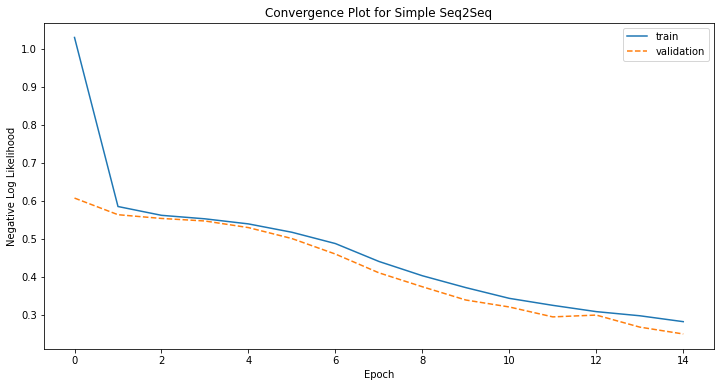

In [83]:
from keras.callbacks import ModelCheckpoint

best_model_fname = "Files/simple_seq2seq_checkpoint.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss', save_best_only=True, verbose=1)

history = simple_seq2seq.fit(
    X_train, np.expand_dims(Y_train, -1), 
    validation_data=(X_val, np.expand_dims(Y_val, -1)), 
    epochs=15, batch_size=32, verbose=2, callbacks=[best_model_cb])

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], '--', label='validation')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('Epoch')
plt.title('Convergence Plot for Simple Seq2Seq')
plt.legend()
plt.show()

# Step 6: Decoding and Evaluating the Seq2Seq Model

In [84]:
def greedy_translate(model, source_sequence, shared_vocab, rev_shared_vocab, word_level_source=True, word_level_target=True):
    # Initialize the list of input token ids with the source sequence
    source_tokens = tokenize(source_sequence, word_level=word_level_source)
    input_ids = [shared_vocab.get(t, UNK) for t in source_tokens[::-1]]
    input_ids += [shared_vocab[GO]]

    # Prepare a fixed size numpy array that matches the expected input
    # shape for the model
    input_array = np.empty(shape=(1, model.input_shape[1]),
                           dtype=np.int32)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        # Vectorize a the list of input tokens as 
        # and use zeros padding.
        input_array.fill(shared_vocab[PAD])
        input_array[0, -len(input_ids):] = input_ids
        
        # Predict the next output: greedy decoding with argmax
        next_token_id = model.predict(input_array)[0, -1].argmax()
        
        # Stop decoding if the network predicts end of sentence:
        if next_token_id == shared_vocab[EOS]:
            break
            
        # Otherwise use the reverse vocabulary to map the prediction
        # back to the string space
        decoded_tokens.append(rev_shared_vocab[next_token_id])
        
        # Append prediction to input sequence to predict the next
        input_ids.append(next_token_id)

    separator = " " if word_level_target else ""
    return separator.join(decoded_tokens)


# Test some translations
print("Estimations:")
phrases = [
    "un",
    "deux",
    "trois",
    "onze",
    "quinze",
    "cent trente deux",
    "cent mille douze",
    "sept mille huit cent cinquante neuf",
    "vingt et un",
    "vingt quatre",
    "quatre vingts",
    "quatre vingt onze mille",
    "quatre vingt onze mille deux cent deux",
    "quatre vingt et un",
    "quarante douze", 
    "onze cent soixante vingt quatorze",
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase, shared_vocab, shared_rev_vocab, word_level_target=False)
    print(phrase.ljust(40), translation)

Estimations:
un                                       10
deux                                     20
trois                                    30
onze                                     100
quinze                                   15
cent trente deux                         132
cent mille douze                         122
sept mille huit cent cinquante neuf      68080
vingt et un                              200
vingt quatre                             28
quatre vingts                            40
quatre vingt onze mille                  812
quatre vingt onze mille deux cent deux   8122
quatre vingt et un                       802
quarante douze                           412
onze cent soixante vingt quatorze        1124


## Step 6.1: Accuracy Results

In [85]:
def phrase_accuracy(model, num_sequences, fr_sequences, n_samples=300,
                    decoder_func=greedy_translate):
    correct = []
    n_samples = len(num_sequences) if n_samples is None else n_samples
    for i, num_seq, fr_seq in zip(range(n_samples), num_sequences, fr_sequences):
        if i % 100 == 0:
            print("Decoding %d/%d" % (i, n_samples))
            
        predicted_seq = decoder_func(model, fr_seq, shared_vocab, shared_rev_vocab, word_level_target=False)
        correct.append(num_seq == predicted_seq)
    return np.mean(correct)


print(f"Phrase-level test accuracy: {phrase_accuracy(simple_seq2seq, num_test, fr_test)}\n")
print(f"Phrase-level train accuracy: {phrase_accuracy(simple_seq2seq, num_train, fr_train)}\n")

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level test accuracy: 0.01

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level train accuracy: 0.006666666666666667

